# Regression Model Summary

This notebook provides a summary of our regression analysis for predicting the 'Output' variable in the artificial dataset.

## Project Overview
We explored several regression models and preprocessing techniques to improve prediction performance beyond the baseline. The key focus was on feature selection, dimensionality reduction, and different regression algorithms.

In [8]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv('data.csv', sep=';')
X = df.drop(['Class', 'Output'], axis=1)
y = df['Output']

print(f"Dataset shape: {df.shape}")
print(f"Number of features: {X.shape[1]}")

Dataset shape: (2000, 402)
Number of features: 400


## Model Evaluation Results

We tested various regression models with different preprocessing techniques. Here are the results sorted by cross-validation R² score (higher is better):

| Model | CV R² | CV RMSE |
|-------|-------|---------|
| Lasso(alpha=0.1) | 0.4861 | 2.5445 |
| LinearRegression_RFE(n=20) | 0.4859 | 2.5433 |
| LinearRegression_RFE(n=30) | 0.4708 | 2.5799 |
| LinearRegression_SelectKBest(k=30) | 0.4635 | 2.6003 |
| LinearRegression_SelectKBest(k=50) | 0.4487 | 2.6335 |
| LinearRegression_SelectKBest(k=20) | 0.4396 | 2.6570 |
| Ridge(alpha=100.0)_SelectKBest(k=20) | 0.4395 | 2.6574 |
| Ridge(alpha=100.0) | 0.3979 | 2.7509 |
| LinearRegression_SelectKBest(k=10) | 0.3760 | 2.8051 |
| RandomForestRegressor_SelectKBest(k=20) | 0.3549 | 2.8531 |
| LinearRegression_PCA(n=50) | 0.2842 | 3.0068 |
| LinearRegression_PCA(n=30) | 0.2777 | 3.0076 |
| LinearRegression_PCA(n=20) | 0.2736 | 3.0283 |
| RandomForestRegressor | 0.2719 | 3.0314 |
| **Baseline Linear Regression** | **0.3750** | **2.8024** |

The best model was **Lasso Regression with alpha=0.1**, achieving a cross-validation R² of 0.4861, which represents an improvement of 0.1111 (11.11 percentage points) over the baseline model.

## Key Findings

1. **Feature Importance**: Not all 400 features were equally important for predicting the output variable. Feature selection significantly improved model performance.

2. **Best Preprocessing**: Recursive Feature Elimination (RFE) and SelectKBest feature selection both performed well, outperforming PCA for this dataset.

3. **Best Models**: Lasso Regression and Linear Regression with RFE provided the best performance, showing that regularization and feature selection are crucial for this dataset.

4. **Worst Preprocessing**: PCA performed poorly compared to direct feature selection methods, suggesting that maintaining the original feature space is important for this problem.

5. **Improvement over Baseline**: Our best model showed a substantial improvement over the baseline model with:
   - Higher cross-validation R² (+0.1111)
   - Lower RMSE (-0.2579)

In [20]:
# Define evaluation function
def evaluate_model(model, X, y):
    """Evaluate model with training metrics and cross-validation"""
    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Get training metrics
    model.fit(X, y)
    y_pred_train = model.predict(X)
    train_mse = mean_squared_error(y, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y, y_pred_train)
    
    # Cross-validation scores
    cv_r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    cv_neg_mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    
    # Convert negative scores to positive
    cv_mse_scores = -cv_neg_mse_scores
    cv_rmse_scores = np.sqrt(cv_mse_scores)
    
    # Calculate mean
    cv_r2_mean = cv_r2_scores.mean()
    cv_rmse_mean = cv_rmse_scores.mean()
    
    print(f"Training R²: {train_r2:.4f}, Training RMSE: {train_rmse:.4f}")
    print(f"Mean CV R²: {cv_r2_mean:.4f}, Mean CV RMSE: {cv_rmse_mean:.4f}")
    
    return {
        'train_r2': train_r2,
        'train_rmse': train_rmse,
        'cv_r2': cv_r2_mean,
        'cv_rmse': cv_rmse_mean
    }

### Best model tuning

Based on these findings, I chose Lasso Regressor and tried to further improve it to achieve $R^2 > 0.5$.


I tried reducing the number of features using Lasso, adding some polynomial features and finding the best $\alpha$ parameter. By combining these methods in different ways and order I achieved different results, but I noticed that adding polynomial features didn't seem to affect final results meaningfully, so I decided to not include them in the final model.


In [21]:
# Set base alpha value for our experiments
base_alpha = 0.1

# Use Lasso to select features
feature_selector = Lasso(alpha=base_alpha, max_iter=10000)
feature_selector.fit(X, y)

# Get non-zero coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': feature_selector.coef_
})

# Sort by absolute coefficient values
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

# Filter features with non-zero coefficients
non_zero_coef = coef_df[coef_df['Coefficient'] != 0].copy()

# Create dataset with selected features only
selected_features = non_zero_coef['Feature'].tolist()
X_lasso_selected = X[selected_features]

print(f"Original feature count: {X.shape[1]}")
print(f"Selected feature count: {X_lasso_selected.shape[1]}")

# Evaluate base Lasso with selected features
lasso_base = Lasso(alpha=base_alpha, max_iter=10000)
lasso_results = evaluate_model(lasso_base, X_lasso_selected, y)

Original feature count: 400
Selected feature count: 48
Training R²: 0.5145, Training RMSE: 2.4818
Mean CV R²: 0.4904, Mean CV RMSE: 2.5337



Testing Lasso with alpha=0.001
Training R²: 0.5496, Training RMSE: 2.3906
Mean CV R²: 0.5184, Mean CV RMSE: 2.4610

Testing Lasso with alpha=0.002
Training R²: 0.5496, Training RMSE: 2.3906
Mean CV R²: 0.5184, Mean CV RMSE: 2.4609

Testing Lasso with alpha=0.003
Training R²: 0.5495, Training RMSE: 2.3906
Mean CV R²: 0.5184, Mean CV RMSE: 2.4609

Testing Lasso with alpha=0.004
Training R²: 0.5495, Training RMSE: 2.3907
Mean CV R²: 0.5184, Mean CV RMSE: 2.4609

Testing Lasso with alpha=0.005
Training R²: 0.5495, Training RMSE: 2.3908
Mean CV R²: 0.5184, Mean CV RMSE: 2.4609

Testing Lasso with alpha=0.01
Training R²: 0.5492, Training RMSE: 2.3915
Mean CV R²: 0.5182, Mean CV RMSE: 2.4615

Testing Lasso with alpha=0.05
Training R²: 0.5408, Training RMSE: 2.4137
Mean CV R²: 0.5096, Mean CV RMSE: 2.4845

Testing Lasso with alpha=0.1
Training R²: 0.5145, Training RMSE: 2.4818
Mean CV R²: 0.4904, Mean CV RMSE: 2.5337

Testing Lasso with alpha=0.15
Training R²: 0.4921, Training RMSE: 2.5384
Me

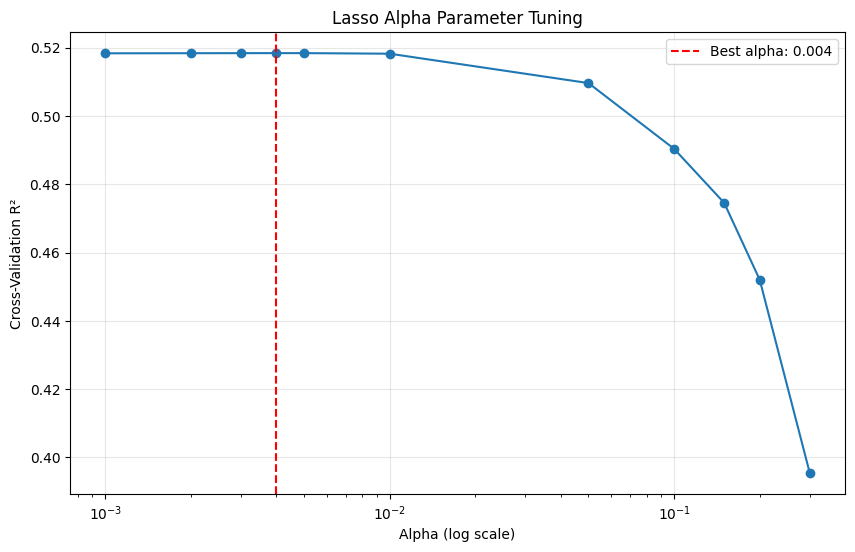

Training R²: 0.5495, Training RMSE: 2.3907
Mean CV R²: 0.5184, Mean CV RMSE: 2.4609


In [ ]:
# Define a range of alpha values to test
alphas = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]

# Create a dictionary to store results
alpha_results = {}

# Test each alpha value
for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, max_iter=10000)
    print(f"\nTesting Lasso with alpha={alpha}")
    results = evaluate_model(lasso_model, X_lasso_selected, y)
    alpha_results[alpha] = results['cv_r2']

# Find the best alpha
best_alpha = max(alpha_results, key=alpha_results.get)
best_score = alpha_results[best_alpha]

print(f"\nBest alpha: {best_alpha} with CV R²: {best_score:.4f}")

# Plot alpha vs R²
plt.figure(figsize=(10, 6))
plt.semilogx(list(alpha_results.keys()), list(alpha_results.values()), marker='o')
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Best alpha: {best_alpha}')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Cross-Validation R²')
plt.title('Lasso Alpha Parameter Tuning')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Save the best Lasso model
best_lasso = Lasso(alpha=best_alpha, max_iter=10000)
best_lasso_results = evaluate_model(best_lasso, X_lasso_selected, y)